## Land Use Classification | CNN Model with Data Augmentation

This notebook explores training a convolutional neural network on a more robust dataset created using data augmentation and incorporating dropout regularization into the model.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

from keras.layers import Activation, BatchNormalization
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

%matplotlib inline

Using TensorFlow backend.


In [4]:
# set up reproducible environment
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed = 123
random.seed(456)
tf.set_random_seed(789)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

In [7]:
image_path = 'dataset/land-use-jpeg/train/River/River_1.jpg'

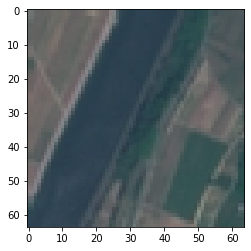

In [8]:
# Obtain image
image = np.expand_dims(plt.imread(image_path), 0)
plt.imshow(image[0])
plt.show()

In [9]:
# Generate batched of augmented images from this image
aug_iter = gen.flow(image) #takes numpy data and returns batches of augmented dat

In [10]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

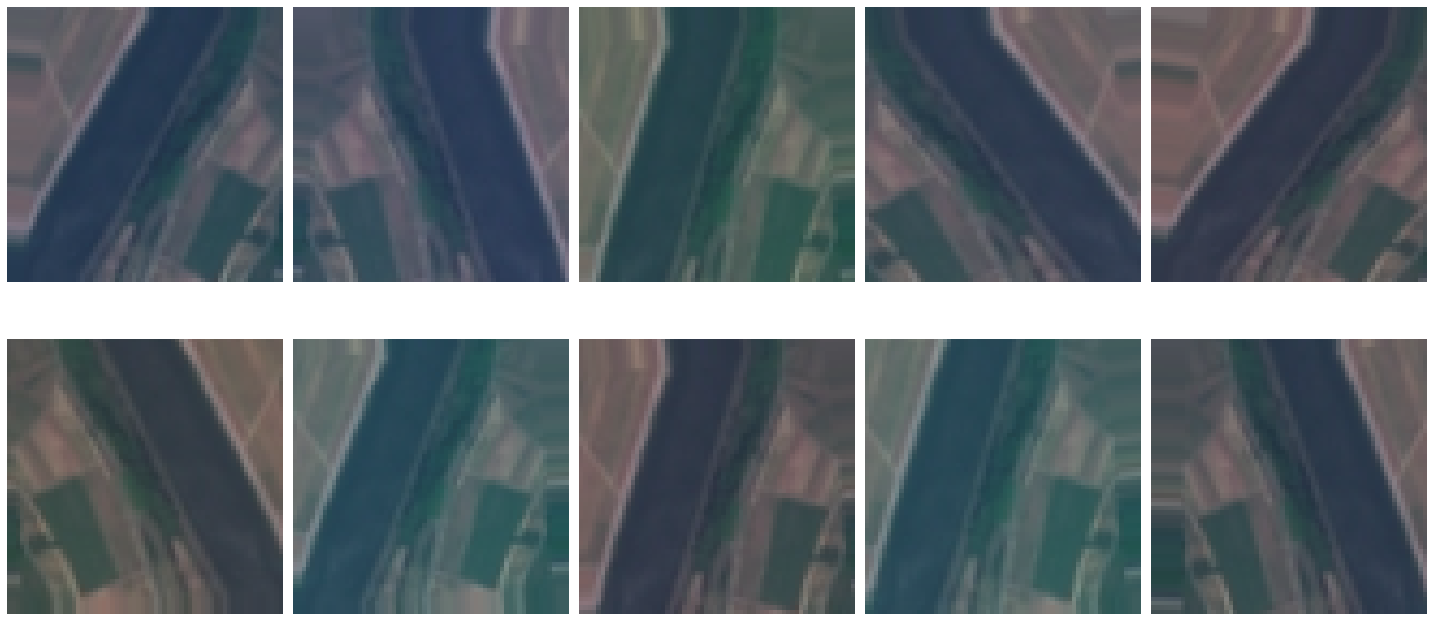

In [11]:
# Augmented images
plots(aug_images, figsize=(20, 10), rows=2)

### Data Preparation

In [12]:
base_path= 'dataset/'
train_path = os.path.join(base_path, 'land-use-jpeg/train')
valid_path = os.path.join(base_path, 'land-use-jpeg/valid')
test_path = os.path.join(base_path, 'land-use-jpeg/test')

In [13]:
categories = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(base_path, 'land-use-tif')):
    categories.extend(dirnames)

In [14]:
# ImageDataGenerator for transformations
train_gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

In [15]:
train_batches = train_gen.flow_from_directory(train_path,
                                              target_size=(64, 64),
                                              classes=categories,
                                              batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)

Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [16]:
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims) //rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [17]:
imgs, labels = next(train_batches)

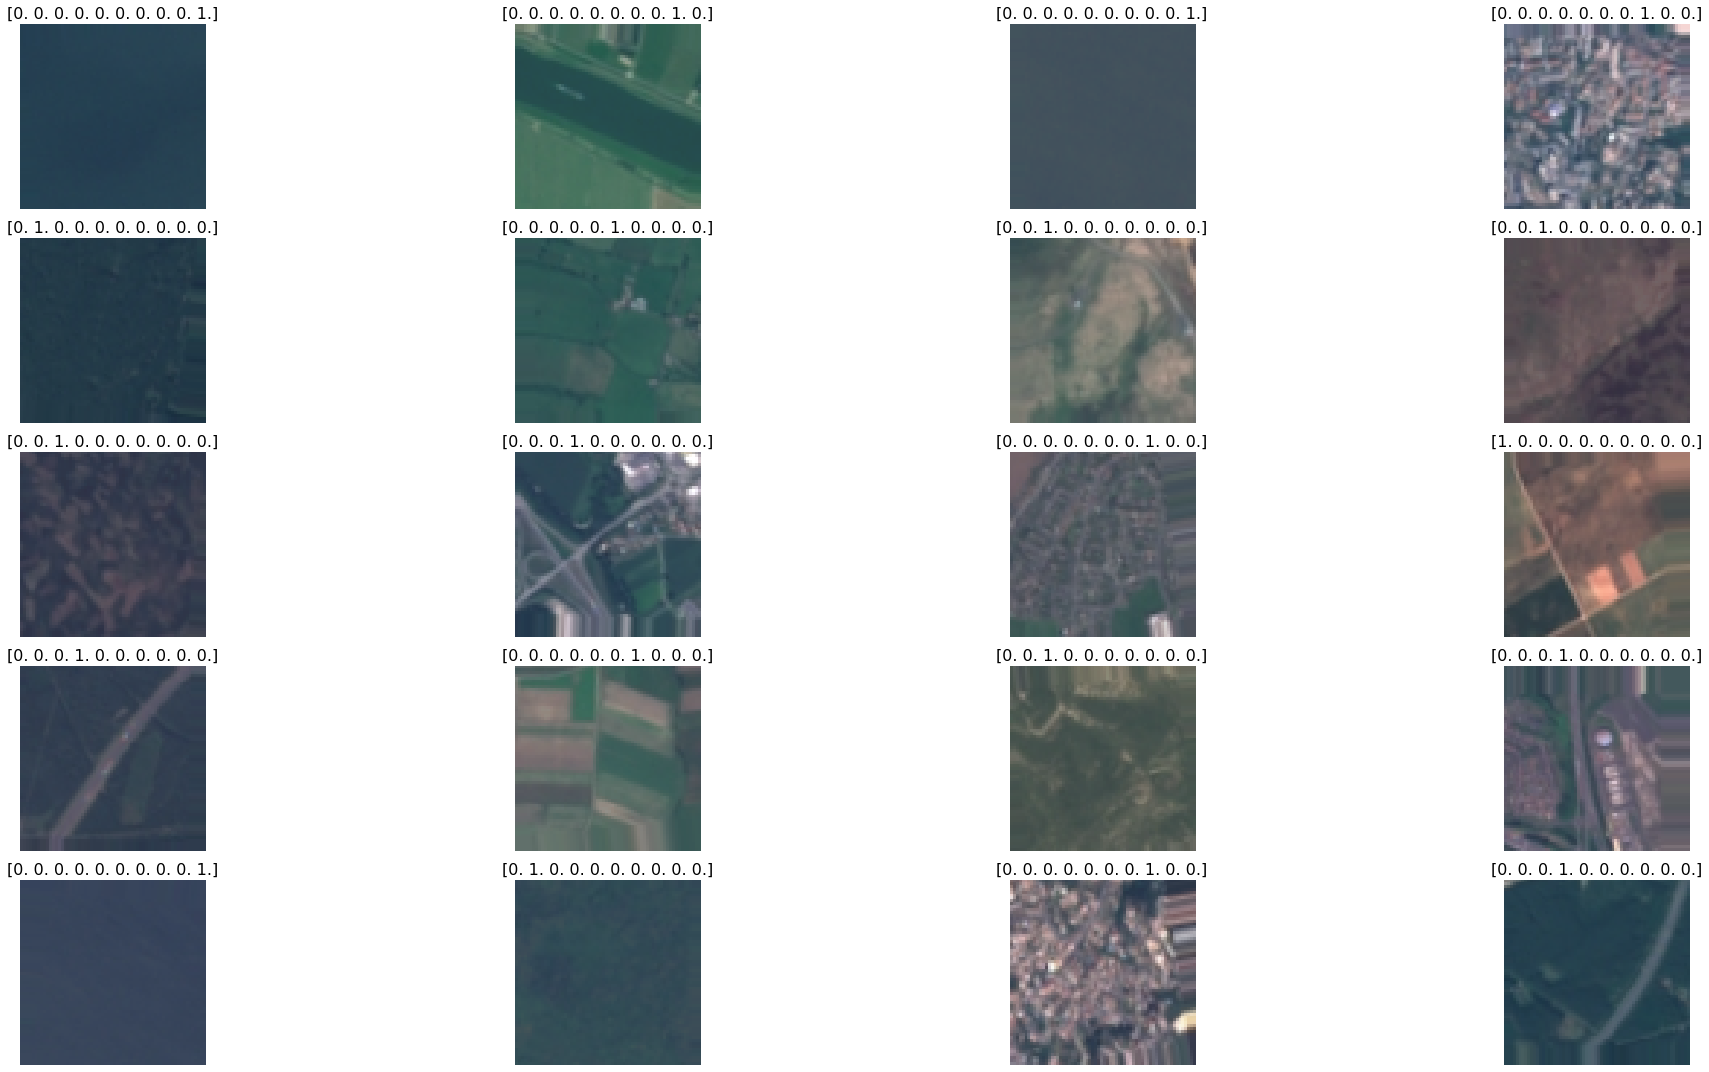

In [18]:
# examples of the input data
plots(imgs, rows=5, titles=labels)

### Build CNN

In [19]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [21]:
# add dropout layers to the model
model = Sequential()
for layer in vgg16_model.layers:
    if "pool" in layer.name:
        model.add(BatchNormalization())
    model.add(layer)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

In [23]:
# freeze the first three layers of the model
NUM_TRAINABLE_LAYERS = len(vgg16_model.layers) - 3
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

In [24]:
# add layers to the end of the model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [25]:
# final model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

###  Train CNN

In [26]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit_generator(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=10,
                   verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10


### Predicting on the test set

In [ ]:
test_labels = test_batches.classes
test_labels

In [ ]:
test_batches.class_indices

In [ ]:
predictions = model.predict_generator(test_batches, steps=270, verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
# save model
model.save('land_use_model_2.h5')